# 코사인 유사도

**예) Numpy의 dot과 norm을 사용해서 문서 단어 행렬에 대한 코사인 유사도 함수를 구현하기**

문서 1 : 저는 사과 좋아요<br>
문서 2 : 저는 바나나 좋아요<br>
문서 3 : 저는 바나나 좋아요 저는 바나나 좋아요

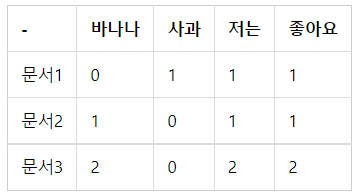

In [1]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

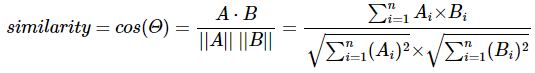

In [2]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [3]:
doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

In [4]:
print('문서 1과 문서2의 유사도 :',cos_sim(doc1, doc2))
print('문서 1과 문서3의 유사도 :',cos_sim(doc1, doc3))
print('문서 2와 문서3의 유사도 :',cos_sim(doc2, doc3))

문서 1과 문서2의 유사도 : 0.6666666666666667
문서 1과 문서3의 유사도 : 0.6666666666666667
문서 2와 문서3의 유사도 : 1.0000000000000002


# 유사도를 이용한 추천 시스템 구현하기

**영화 데이터셋을 가지고 영화를 입력하면, 해당 영화의 줄거리와 유사한 줄거리의 영화를 찾아 추천하는 영화 추천 시스템 만들기**

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**1) 원본 파일인 총 24개의 열을 가진 45466개의 샘플로 구성된 영화 정보 데이터 movies_metadata.csv 파일을 다운받기**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
PATH = '/content/drive/MyDrive/Colab Notebooks/dataset/'

**2) 다운로드 받은 훈련 데이터에서 상위 2개의 샘플만 출력하여 데이터의 형식을 확인**

In [11]:
data = pd.read_csv(PATH + 'movies_metadata.csv', encoding = 'utf-8-sig', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


**3) 훈련 데이터의 양을 줄이기 위해 데이터를 줄여서 상위 20000개의 샘플만 재저장**

In [12]:
data = data.head(20000)

**4) TF-IDF를 연산할 때 데이터에 Null 값이 들어있으면 에러가 발생하므로 data의 overview(줄거리) 열의 결측값 확인**

In [13]:
print('overview 열의 결측값의 수:',data['overview'].isnull().sum())

overview 열의 결측값의 수: 135


**5) 결측값을 가진 행을 빈 값으로 대체**

In [14]:
data['overview'] = data['overview'].fillna('')

**6) overview 열에 대해서 TF-IDF 행렬을 구한 후 행렬의 크기를 출력하면 20000개의 행을 가지고 47847의 열을 가짐**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**이는 20000개의 영화를 표현하기 위해서 총 47487개의 단어가 사용되었음을 의미하며**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**이는 47487 차원의 문서 벡터가 20000개 존재한다는 의미**

In [15]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print('TF-IDF 행렬의 크기(shape) :',tfidf_matrix.shape)

TF-IDF 행렬의 크기(shape) : (20000, 47487)


**7) 20000개의 문서 벡터에 대해서 상호 간의 코사인 유사도를 구하여 20000행 20000열의 행렬을 얻음**

In [16]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [17]:
print('코사인 유사도 연산 결과 :',cosine_sim.shape)

코사인 유사도 연산 결과 : (20000, 20000)


**8) 기존 데이터프레임으로부터 영화의 타이틀을 key, 영화의 인덱스를 value로 하는 딕셔너리를 생성**

In [18]:
title_to_index = dict(zip(data['title'], data.index))

In [19]:
idx = title_to_index['Father of the Bride Part II']
print(idx)

4


**9) 선택한 영화의 제목을 입력하면 코사인 유사도를 통해 가장 overview가 유사한 10개의 영화를 찾아내는 함수를 생성**

In [20]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = title_to_index[title]

    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[1:11]

    movie_indices = [idx[0] for idx in sim_scores]

    return data['title'].iloc[movie_indices]

**10) 영화 다크 나이트 라이즈와 overview가 유사한 영화를 찾아보면 다크 나이트를 제외하고는 전부 배트맨 영화를 찾아냄**

In [21]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object